In [1]:
%load_ext autoreload
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34
from torch import nn
import torch.optim as optim
from torch import nn
import copy
import pruning_funcs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Transform and Load CIFAR-10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data/train', train=True, download=True,transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data/test', train=False, download=True,transform=transform_test)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Modify ResNet34 Architecture for CIFAR-10
class ModifiedResNet34(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedResNet34, self).__init__()
        self.model = resnet34(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.avgpool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), nn.Dropout(0.5))  
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

In [4]:
# Setup GPU 
device = torch.device("mps")
model = ModifiedResNet34().to(device)

/Users/jtschuler/Illinois/cs521/probabilistic-pruning/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jtschuler/Illinois/cs521/probabilistic-pruning/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def evaluate_model(testing_model, dataloader, suppress_output=False):
    testing_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = testing_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if not suppress_output:
        print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

In [6]:
# Loss function, optimizer, hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

In [7]:
# Traning Loop
def train_model(model, debug_interval = 200, save_model=True, use_saved_state=True):
    for epoch in range(num_epochs):  
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Print statistics
            running_loss += loss.item()
            if i % debug_interval == debug_interval-1:
                print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss: {running_loss / 200:.4f}')
                print(f'\tAcc (Test data): {evaluate_model(model, testloader, suppress_output=True)}')
                running_loss = 0.0
    if save_model:
        torch.save(model.state_dict(), "resnet_state")
    print('Finished Training')

In [8]:
# train_model(model, debug_interval = 200, save_model=True)
# Load the state dictionary from the file
state_dict = torch.load("resnet_state")
new_state_dict = {f'model.{k}': v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
evaluate_model(model, testloader)

Accuracy of the model on the test images: 95.46%


95.46

# Pruning methods begin here

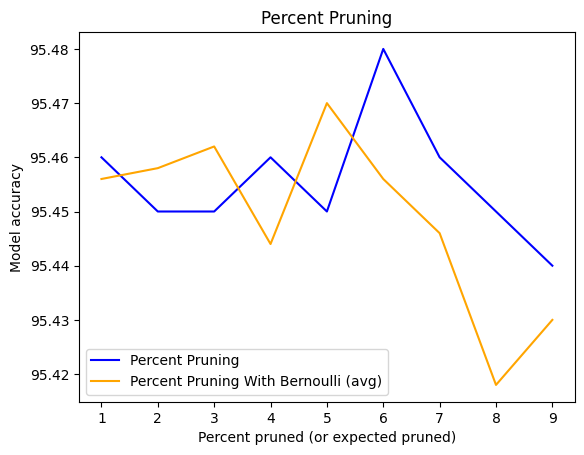

In [9]:
# Bernoulli Pruning
%autoreload now

percent_prune = []
percent_prune_with_bernoulli = []
percents = np.arange(1,10,1)

for percent in percents:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.bottom_percent_prune(pruned_model, device, percent=percent)
    percent_prune.append(evaluate_model(pruned_model, testloader, suppress_output=True))
    
    ppwb_runs = []
    for i in range(5):
        pruned_model_2 = copy.deepcopy(model)
        pruning_funcs.percent_prune_with_bernoulli(pruned_model_2, device, percent=(2*percent), p_success=0.5)
        ppwb_runs.append(evaluate_model(pruned_model_2, testloader, suppress_output=True))

    percent_prune_with_bernoulli.append(np.mean(ppwb_runs))

fig, ax = plt.subplots()
ax.set_title("Percent Pruning")
line1, = ax.plot(percents, percent_prune, color='blue')
line2, = ax.plot(percents, percent_prune_with_bernoulli, color='orange')
line1.set_label("Percent Pruning")
line2.set_label("Percent Pruning With Bernoulli (avg)")
ax.legend()
ax.set_xlabel("Percent pruned (or expected pruned)")
ax.set_ylabel("Model accuracy")
ax.set_xticks(percents)

Text(0.5, 0, 'Scale = 0.25')

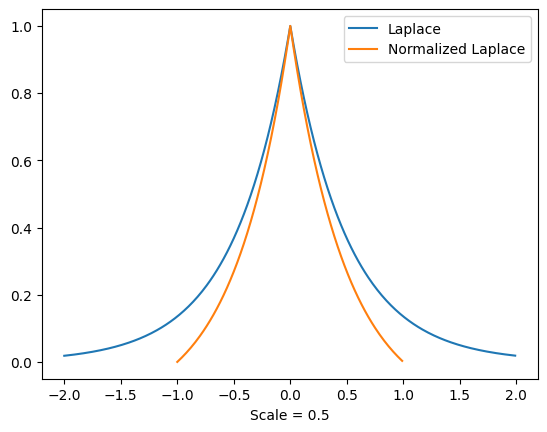

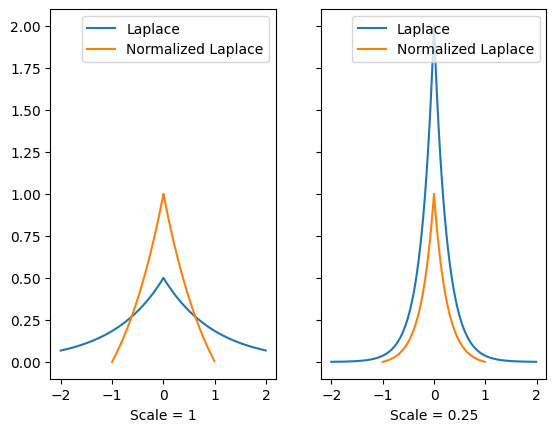

In [10]:
# Graph Laplace Distribution

def laplace_at(x, loc=0, scale=0.5):
    return np.exp(-abs(x-loc)/scale)/(2.*scale)

def graph_laplace_and_normalized(scale, loc=0, min=1):
    x = np.arange(-2, 2, 0.01)
    normalized_x = np.arange(-1, 1, 0.01)

    laplace_dist = lambda y: laplace_at(y, scale=scale, loc=loc)
    pdf = laplace_dist(x)
    normalized_pdf = (laplace_dist(normalized_x) - laplace_dist(min)) / (laplace_dist(loc) - laplace_dist(min))
    return ((x, pdf),(normalized_x, normalized_pdf))

((x, pdf), (x2, modified_pdf)) = graph_laplace_and_normalized(0.5)
fig, ax = plt.subplots()
line1, = ax.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax.legend()
ax.set_xlabel('Scale = 0.5')

((x, pdf), (x2, modified_pdf)) = graph_laplace_and_normalized(1)
((x3, pdf2), (x4, modified_pdf2)) = graph_laplace_and_normalized(0.25)

fig2, (ax1, ax2) = plt.subplots(1,2, sharey=True)
line1, = ax1.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax1.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax1.legend()
ax1.set_xlabel('Scale = 1')
line3, = ax2.plot(x3, pdf2)
line3.set_label('Laplace')
line4, = ax2.plot(x4, modified_pdf2)
line4.set_label('Normalized Laplace')
ax2.legend()
ax2.set_xlabel('Scale = 0.25')


In [11]:
%autoreload now

tests = np.arange(0.002, 0.021, 0.002)
num_trials = 5

print()
print('Avg. accuracy at scale values for Normalized Laplace Distribution')

print()
print('Unpruned Model')
accuracy = evaluate_model(model, testloader, suppress_output=True)
percent_zero = pruning_funcs.percent_zero_weights(model)
print(f'Accuracy: {accuracy:.2f}%\tPercent Zero: {percent_zero:.2f}%')

print()
print("Pruned Models (Normalized Laplace)")
for prune_scale in tests:
    accuracy = 0.
    percent_zeros = 0.
    for i in range(num_trials):
        pruned_model = copy.deepcopy(model)
        pruning_funcs.normalized_laplace_prune(pruned_model, device, scale=prune_scale)
        accuracy += evaluate_model(pruned_model, testloader, suppress_output=True)
        percent_zeros += pruning_funcs.percent_zero_weights(pruned_model)
    accuracy /= num_trials
    percent_zeros /= num_trials
    print(f'Scale: {prune_scale:.3f}\tAvg. Accuracy: {accuracy:.2f}%\tAvg. Percent Zero: {percent_zeros:.2f}%')


Avg. accuracy at scale values for Normalized Laplace Distribution

Unpruned Model
Accuracy: 95.46%	Percent Zero: 0.00%

Pruned Models (Normalized Laplace)
Scale: 0.002	Avg. Accuracy: 95.39%	Avg. Percent Zero: 11.90%
Scale: 0.004	Avg. Accuracy: 95.37%	Avg. Percent Zero: 22.31%
Scale: 0.006	Avg. Accuracy: 95.02%	Avg. Percent Zero: 30.94%
Scale: 0.008	Avg. Accuracy: 94.58%	Avg. Percent Zero: 38.03%
Scale: 0.010	Avg. Accuracy: 93.95%	Avg. Percent Zero: 43.87%
Scale: 0.012	Avg. Accuracy: 93.12%	Avg. Percent Zero: 48.75%
Scale: 0.014	Avg. Accuracy: 91.58%	Avg. Percent Zero: 52.87%
Scale: 0.016	Avg. Accuracy: 89.95%	Avg. Percent Zero: 56.38%
Scale: 0.018	Avg. Accuracy: 86.80%	Avg. Percent Zero: 59.42%
Scale: 0.020	Avg. Accuracy: 81.18%	Avg. Percent Zero: 62.06%


In [12]:
%autoreload now

percents = np.arange(5,51,5)
print()
print("Pruned Models (Standard Percent Pruning By Layer)")
for percent in percents:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.percent_prune_by_layer(pruned_model, device, percent=percent)
    accuracy = evaluate_model(pruned_model, testloader, suppress_output=True)
    percent_zero = pruning_funcs.percent_zero_weights(pruned_model)
    print(f'Theoretic percent pruned: {percent}%\tActual percent pruned: {percent_zero:.2f}%\tAccuracy: {accuracy:.2f}%')


Pruned Models (Standard Percent Pruning By Layer)
Theoretic percent pruned: 5%	Actual percent pruned: 5.00%	Accuracy: 93.98%
Theoretic percent pruned: 10%	Actual percent pruned: 10.00%	Accuracy: 91.11%
Theoretic percent pruned: 15%	Actual percent pruned: 15.00%	Accuracy: 84.52%
Theoretic percent pruned: 20%	Actual percent pruned: 20.00%	Accuracy: 73.08%
Theoretic percent pruned: 25%	Actual percent pruned: 25.00%	Accuracy: 47.19%
Theoretic percent pruned: 30%	Actual percent pruned: 30.00%	Accuracy: 20.78%
Theoretic percent pruned: 35%	Actual percent pruned: 35.00%	Accuracy: 13.08%
Theoretic percent pruned: 40%	Actual percent pruned: 40.00%	Accuracy: 10.03%
Theoretic percent pruned: 45%	Actual percent pruned: 45.00%	Accuracy: 10.10%
Theoretic percent pruned: 50%	Actual percent pruned: 50.00%	Accuracy: 9.97%


In [13]:
%autoreload now

percents = np.arange(5,51,5)
print()
print("Pruned Models (Standard Bottom Percent Pruning)")
for percent in percents:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.bottom_percent_prune(pruned_model, device, percent=percent)
    accuracy = evaluate_model(pruned_model, testloader, suppress_output=True)
    percent_zero = pruning_funcs.percent_zero_weights(pruned_model)
    print(f'Theoretic percent pruned: {percent}%\tActual percent pruned: {percent_zero:.2f}%\tAccuracy: {accuracy:.2f}%')



Pruned Models (Standard Bottom Percent Pruning)
Theoretic percent pruned: 5%	Actual percent pruned: 5.00%	Accuracy: 95.45%
Theoretic percent pruned: 10%	Actual percent pruned: 10.00%	Accuracy: 95.50%
Theoretic percent pruned: 15%	Actual percent pruned: 15.00%	Accuracy: 95.34%
Theoretic percent pruned: 20%	Actual percent pruned: 20.00%	Accuracy: 95.36%
Theoretic percent pruned: 25%	Actual percent pruned: 25.00%	Accuracy: 95.34%
Theoretic percent pruned: 30%	Actual percent pruned: 30.00%	Accuracy: 95.28%
Theoretic percent pruned: 35%	Actual percent pruned: 35.00%	Accuracy: 95.38%
Theoretic percent pruned: 40%	Actual percent pruned: 40.00%	Accuracy: 95.25%
Theoretic percent pruned: 45%	Actual percent pruned: 45.00%	Accuracy: 95.16%
Theoretic percent pruned: 50%	Actual percent pruned: 50.00%	Accuracy: 94.91%


In [14]:
%autoreload now

thresholds = np.arange(0.002, 0.021, 0.002)

print()
print("Pruned Models (Standard Threshold Pruning)")
for threshold in thresholds:
    pruned_model = copy.deepcopy(model)
    pruning_funcs.threshold_prune(pruned_model, threshold)
    accuracy = evaluate_model(pruned_model, testloader, suppress_output=True)
    percent_zero = pruning_funcs.percent_zero_weights(pruned_model)
    print(f'Threshold: {threshold:.3f}\tPercent pruned: {percent_zero:.2f}%\tAccuracy: {accuracy:.2f}%')



Pruned Models (Standard Threshold Pruning)
Threshold: 0.002	Percent pruned: 12.17%	Accuracy: 95.46%
Threshold: 0.004	Percent pruned: 23.93%	Accuracy: 95.39%
Threshold: 0.006	Percent pruned: 35.04%	Accuracy: 95.35%
Threshold: 0.008	Percent pruned: 45.28%	Accuracy: 95.26%
Threshold: 0.010	Percent pruned: 54.49%	Accuracy: 94.86%
Threshold: 0.012	Percent pruned: 62.55%	Accuracy: 94.12%
Threshold: 0.014	Percent pruned: 69.48%	Accuracy: 92.73%
Threshold: 0.016	Percent pruned: 75.32%	Accuracy: 89.30%
Threshold: 0.018	Percent pruned: 80.14%	Accuracy: 82.27%
Threshold: 0.020	Percent pruned: 84.08%	Accuracy: 60.97%
